In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import xarray as xr
import pandas as pd
import pytz
from datetime import datetime as dt
from datetime import timedelta, timezone
import sys,os,glob
import IPython
from matplotlib import cm
import matplotlib.image as mpimg
from math import ceil

# geodesic distances and displacements
import geopy
import geopy.distance
# map display
import cartopy.crs as ccrs

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

In [2]:
workdir = os.getcwd()
rootdir = os.path.dirname(workdir)
figdir = os.path.join(rootdir,'figures','exploreRadiativeCoolingPeak')
if not os.path.exists(figdir): os.makedirs(figdir)

In [3]:
day = '20200126'
date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))

lat_box = 11,16
lon_box = -60,-52

lat_box_goes = 10,16
lon_box_goes = -60,-52

In [4]:
indir_sonde_qrad = '/Users/bfildier/Dropbox/Data/EUREC4A/sondes_radiative_profiles/'
indir_goes_images = '/Users/bfildier/Data/satellite/GOES/images/%s'%date.strftime('%Y_%m_%d')

In [5]:
print('load GOES images')
image_vis_files = glob.glob(os.path.join(indir_goes_images,'*C02*00.jpg'))
image_vis_files.sort()

image_IR_files = glob.glob(os.path.join(indir_goes_images,'*C13*00.jpg'))
image_IR_files.sort()

# in the visible channel
images_vis = []
for i in range(len(image_vis_files)):
    images_vis.append(mpimg.imread(image_vis_files[i]))
    
# in the IR channel
images_IR = []
for i in range(len(image_IR_files)):
    images_IR.append(mpimg.imread(image_IR_files[i]))


load GOES images


In [6]:
print('load rad profiles')
# radprf = xr.open_dataset(os.path.join(indir_sonde_qrad,'rad_profiles.nc'))
radprf = xr.open_dataset(os.path.join(indir_sonde_qrad,'rad_profiles_CF.nc'))

load rad profiles


In [7]:
list_times = list(radprf.launch_time.values)
list_times.sort()

In [8]:
for i in range(len(list_times)-1):
    if list_times[i] == list_times[i+1]:
        print(list_times[i])

2020-01-31T22:45:01.000000000
2020-02-02T16:22:22.000000000
2020-02-13T14:41:16.000000000


In [9]:
print('convert times to datetime objects')
# # NO NEED ANYMORE
# timestamps = [int(lt/1e9) for lt in radprf.launch_time.values]
# times = [dt.fromtimestamp(ts)-timedelta(hours=1) for ts in timestamps] # removing 1 hour apparently necessary to match the original sonde time
# # double check that (t-dt(1970,1,1)).total_seconds() gives the same time stamp
# radprf = radprf.assign(launch_time=times) # reassign to object

convert times to datetime objects


# Show profiles for one day

## Select profiles

In [10]:
print("remove profiles with missing data and select current day")

data_day = radprf.where(radprf.z_min<=50,drop=True).sel(launch_time=day)

remove profiles with missing data and select current day


In [11]:
print("calculate PW with humidity data saved in rad profiles")

data = data_day

def computePW(data):

    # qv
    qv = data.specific_humidity.values
    # density
    t_lay = data.temperature.values
    R = 287 # J/kg/K
    p_lay = data.pressure.values
    rho_lay = p_lay/(R*t_lay)
    # dz
    dz = np.diff(data.alt_edges)
    dz_3D = np.repeat(dz[np.newaxis,:],t_lay.shape[0],axis=0)
    # PW
    pw = np.nansum(qv[:,:-2]*rho_lay[:,:-2]*dz_3D,axis=1)
    
    return pw

pw = computePW(data)

calculate PW with humidity data saved in rad profiles


In [12]:
print('choose profiles for that day that start at bottom')
data_day = radprf.where(radprf.z_min<=50,drop=True).sel(launch_time=day)
times = np.array([pytz.utc.localize(dt.strptime(str(d)[:19],'%Y-%m-%dT%H:%M:%S')) for d in data_day.launch_time.values])

choose profiles for that day that start at bottom


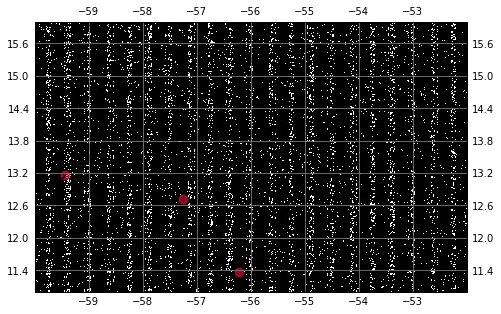

In [13]:
i_h = 6

time_init = pytz.utc.localize(dt(2020,1,26))

mask_hour = np.logical_and(times > time_init+timedelta(hours=i_h), times <= time_init+timedelta(hours=i_h+1))
data_hour = data_day.sel(launch_time=mask_hour)
im_hour = images_vis[i_h]

# data_hour.latitude.dropna(dim='zlay')[:,0]

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(np.diff(lon_box),np.diff(lat_box)))

ax.coastlines(resolution='50m')
ax.set_extent([*lon_box,*lat_box])
gl = ax.gridlines(color='Grey',draw_labels=True)
# gl.xlabel_style = {'size': 16}
# gl.ylabel_style = {'size': 16}

# show background
ax.imshow(im_hour,extent=[*lon_box_goes,*lat_box_goes],origin='upper')

# show sondes
x_s = data_hour.longitude.dropna(dim='alt')[:,0]
y_s = data_hour.latitude.dropna(dim='alt')[:,0]

m = ax.scatter(x_s,y_s,marker='o',color='crimson',alpha=0.6,s=80,label='Dropsondes')


example for given hour slice


Text(0, 0.5, 'Latitude')

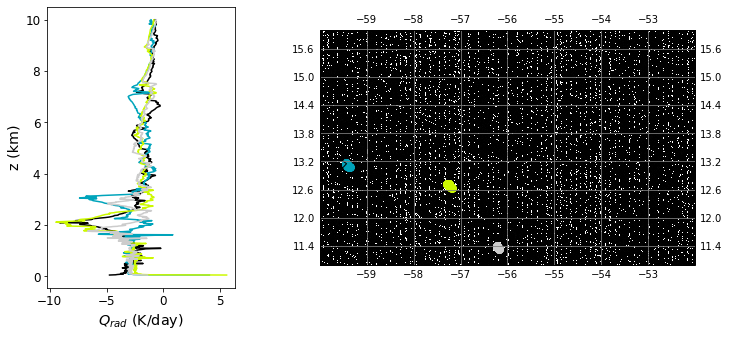

In [14]:
print('example for given hour slice')

i_h = 6

time_init = pytz.utc.localize(dt(2020,1,26))
timedelta(hours=i_h)

mask_hour = np.logical_and(times > time_init+timedelta(hours=i_h), times <= time_init+timedelta(hours=i_h+1))
data_hour = data_day.sel(launch_time=mask_hour)
im_hour = images_vis[i_h]

cols = [plt.cm.nipy_spectral(x) for x in np.linspace(0,1,data_hour.dims['launch_time'])]

fig = plt.figure(figsize=(np.diff(lon_box)*3/2,np.diff(lat_box)))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

## (a) Q_rad profiles

ax = plt.subplot(gs[0])
for i_lt in range(data_hour.dims['launch_time']):
    ax.plot(data_hour.q_rad[i_lt],data_day.alt/1e3,alpha=1,c=cols[i_lt])
    
ax.set_xlabel(r'$Q_{rad}$ (K/day)')
ax.set_ylabel(r'z (km)')

## (b) sonde location
    
ax = plt.subplot(gs[1],projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.set_extent([*lon_box,*lat_box])
gl = ax.gridlines(color='Grey',draw_labels=True)
# gl.xlabel_style = {'size': 16}
# gl.ylabel_style = {'size': 16}

# show background
ax.imshow(im_hour,extent=[*lon_box_goes,*lat_box_goes],origin='upper')

# show sondes
x_s = data_hour.longitude.dropna(dim='alt')
y_s = data_hour.latitude.dropna(dim='alt')
col = plt.rcParams['axes.prop_cycle'].by_key()['color'][:x_s.size]

for i_s in range(x_s.shape[0]):
    
    ax.scatter(x_s[i_s,:],y_s[i_s,:],marker='o',color=cols[i_s],alpha=0.9,s=50,label='Dropsondes')

ax.set_xlabel(r'Longitude')
ax.set_ylabel(r'Latitude')


In [15]:
print("Get sunrise and sunset for that day")

from astral import LocationInfo
from astral.sun import sun

city = LocationInfo("Barbados", "Barbados", "Etc/GMT", 3.1939,-59.5432)
s = sun(city.observer, date=date,tzinfo=city.timezone)
time_sunrise = s['sunrise']
time_sunset = s['sunset']
print(time_sunrise,time_sunset)


Get sunrise and sunset for that day
2020-01-26 10:11:36.082928+00:00 2020-01-26 22:09:42.745658+00:00


In [16]:
def getMaskXYT(data_day,time_current,lon_box,lat_box,time_mode=None):

    times = np.array([pytz.utc.localize(dt.strptime(str(d)[:19],'%Y-%m-%dT%H:%M:%S')) for d in data_day.launch_time.values])
    
    if time_mode == 'hour':
        mask_hour = np.logical_and(times > time_current, times <= time_current+timedelta(hours=1))
    else:
        mask_hour = np.ones((times.size),dtype=bool)
        
    mask_lat = np.logical_and(np.nanmean(data_day.latitude.values,axis=1) > lat_box[0],
                              np.nanmean(data_day.latitude.values,axis=1) < lat_box[1])
    mask_lon = np.logical_and(np.nanmean(data_day.longitude.values,axis=1) > lon_box[0],
                              np.nanmean(data_day.longitude.values,axis=1) < lon_box[1])
    mask = np.logical_and(np.logical_and(mask_lat,mask_lon), mask_hour)
    
    return mask

In [17]:
print("display for all hours on that day")

# times = np.array([pytz.utc.localize(dt.strptime(str(d)[:19],'%Y-%m-%dT%H:%M:%S')) for d in data_day.launch_time.values])

for i_h in range(24):

    print(i_h, end=': ')

    time_init = pytz.utc.localize(dt(2020,1,26))
    time_current = time_init+timedelta(hours=i_h)
    time_label = time_current.strftime("%Y%m%d_%H")
    
    # select profiles in hour and display box
    mask = getMaskXYT(data_day,time_current,lon_box,lat_box,time_mode='hour')
    
#     print(np.where(mask)[0])
    data_hour = data_day.sel(launch_time=mask)
    
    # pick the right image (visible or IR according to sunset/sunrise)
    daytime = time_current > time_sunrise and time_current < time_sunset
    if daytime:
        im_hour = images_vis[i_h]
    else:
        im_hour = images_IR[i_h]

    ###--- Plot ---###

    cols = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,data_hour.dims['launch_time'])]

    fig = plt.figure(figsize=(np.diff(lon_box)*3/2,np.diff(lat_box))) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

    ## (a) Q_rad profiles

    ax = plt.subplot(gs[0])
    for i_lt in range(data_hour.dims['launch_time']):
        ax.plot(data_hour.q_rad[i_lt],data_hour.alt/1e3,alpha=1,c=cols[i_lt])

    ax.set_xlabel(r'$Q_{rad}$ (K/day)')
    ax.set_ylabel(r'z (km)')

    ax.set_xlim((None,7))
    ax.set_ylim((-0.5,10.5))
    ax.set_title(r'%s, %dh $\leq$ t $\leq$ %dh'%(date.strftime("%Y-%m-%d"),i_h,i_h+1))
    
    ## (b) sonde location

    ax = plt.subplot(gs[1],projection=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    ax.set_extent([*lon_box,*lat_box])
    gl = ax.gridlines(color='Grey',draw_labels=True)
    # gl.xlabel_style = {'size': 16}
    # gl.ylabel_style = {'size': 16}

    # show background
    ax.imshow(im_hour,extent=[*lon_box_goes,*lat_box_goes],origin='upper')

    # show sondes
    x_s = data_hour.longitude.dropna(dim='alt')
    y_s = data_hour.latitude.dropna(dim='alt')
    col = plt.rcParams['axes.prop_cycle'].by_key()['color'][:x_s.size]

    for i_s in range(x_s.shape[0]):

        ax.scatter(x_s[i_s,:],y_s[i_s,:],marker='o',color=cols[i_s],alpha=0.9,s=10,label='Dropsondes')

    ax.set_xlabel(r'Longitude')
    ax.set_ylabel(r'Latitude')

    plt.savefig(os.path.join(figdir,'qrad_profile_and_position_%s.pdf'%time_label),bbox_inches='tight')
#     plt.show()
    plt.close()

display for all hours on that day
0: 1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 

## Show all sondes and advect them back to midday by the mean wind

compute mean wind direction


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


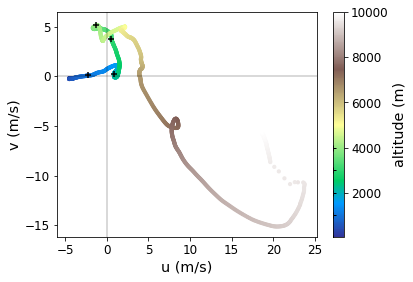

In [19]:
print("compute mean wind direction")

u_mean = data_day.u_wind.mean(axis=0).values
v_mean = data_day.v_wind.mean(axis=0).values
z = data_day.alt.values

# show hodograph
fig,ax = plt.subplots()
ax.axhline(0,c='k',alpha=0.2)
ax.axvline(0,c='k',alpha=0.2)
# h = ax.scatter(u_mean,v_mean,c=plt.cm.terrain(z/z.max()),cmap=plt.cm.terrain)
h = ax.scatter(u_mean,v_mean,c=z,cmap=plt.cm.terrain,s=10)
cb = fig.colorbar(h,ax=ax)

ax.set_xlabel('u (m/s)')
ax.set_ylabel('v (m/s)')
cb.set_label('altitude (m)')

#- Mark points at 1,2,3,4km
for z_ref in (0,1000,2000,3000,4000):
    i_z = np.where(z > z_ref)[0][0]
    
    # add to main plot
    ax.scatter(u_mean[i_z],v_mean[i_z],c='k',marker='+')
    # add to colorbar
    cb.ax.plot(0.7,z_ref,marker='+',c='k')

plt.savefig(os.path.join(figdir,'mean_hodograph_%s.pdf'%date.strftime("%Y%m%d")),bbox_inches='tight')

In [20]:
print("Define advection wind in the first km")

u_adv = np.nanmean(u_mean[z<2000])
v_adv = np.nanmean(v_mean[np.logical_and(z<4000,z>2000)])

print(u_adv,v_adv)

Define advection wind in the first km
-1.8782273648286336 2.950272809808074


In [21]:
# advect back to moving frame
def advect_coords(x,y,u,v,ref_time,cur_time):
    
    # starting position
    start = geopy.Point(y,x)
    
    # distance increment
    dtime = ref_time - cur_time
    delta_s = dtime.days*3600*24+dtime.seconds
    dx_km = delta_s*u/1000
    dy_km = delta_s*v/1000
    d_x = geopy.distance.distance(kilometers = dx_km)
    d_y = geopy.distance.distance(kilometers = dy_km)
    
    # new location
    intermediate = d_x.destination(start,bearing=-90)
    end = d_y.destination(intermediate,bearing=0)
    
    return end.longitude, end.latitude

In [22]:
def advectProperties(advect_u,advect_v,u,v):
    
    u_plot,v_plot = 0,0
    if advect_u:
        u_plot = u
    if advect_v:
        v_plot = v

    advect_lab = 'no_advect'
    if advect_u or advect_v:
        advect_lab = 'advect'+'U'*advect_u+'V'*advect_v
    
    return u_plot,v_plot,advect_lab

In [24]:
data_day

<xarray.Dataset>
Dimensions:            (alt: 1001, alt_edges: 1000, launch_time: 109)
Coordinates:
  * alt                (alt) int32 0 10 20 30 40 ... 9960 9970 9980 9990 10000
  * alt_edges          (alt_edges) int32 5 15 25 35 45 ... 9965 9975 9985 9995
  * launch_time        (launch_time) datetime64[ns] 2020-01-26T13:32:48 ... 2020-01-26T20:45:42
Data variables:
    latitude           (launch_time, alt) float64 nan nan nan ... nan nan nan
    longitude          (launch_time, alt) float64 nan nan nan ... nan nan nan
    platform           (launch_time) object 'ATL' 'ATL' 'ATL' ... 'HALO' 'HALO'
    sounding_id        (launch_time) object 'Atalante__ascent__9.40_-58.89__202001261332' ... 'HALO-0126_s75'
    ascent_flag        (launch_time) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    z_min              (launch_time) float64 40.0 40.0 40.0 ... 40.0 40.0 40.0
    z_max              (launch_time) float64 1.013e+04 1.003e+04 ... 9.61e+03
    temperature        (launch_time, alt) float64 nan nan nan ... 243.6 243.6
    pressure           (launch_time, alt) float64 nan nan ... 3.013e+04
    specific_humidity  (launch_time, alt) float64 nan nan ... 0.0001114
    pressure_edges     (launch_time, alt_edges) float64 nan nan ... 3.004e+04
    sfc_emis           (launch_time) float64 0.98 0.98 0.98 ... 0.98 0.98 0.98
    sfc_alb            (launch_time) float64 0.07 0.07 0.07 ... 0.07 0.07 0.07
    sfc_temperature    (launch_time) float64 299.1 299.1 299.1 ... 299.8 300.0
    cos_sza            (launch_time) float64 0.6758 0.802 ... 0.2497 0.2276
    lw_dn              (launch_time, alt_edges) float64 nan nan ... 60.14 60.03
    lw_up              (launch_time, alt_edges) float64 nan nan ... 339.3 339.3
    lw_net             (launch_time, alt_edges) float64 nan nan ... -279.2
    sw_dn              (launch_time, alt_edges) float64 nan nan ... 272.0 272.0
    sw_up              (launch_time, alt_edges) float64 nan nan ... 34.54 34.55
    sw_net             (launch_time, alt_edges) float64 nan nan ... 237.5 237.5
    relative_humidity  (launch_time, alt) float64 nan nan nan ... nan nan nan
    theta              (launch_time, alt) float64 nan nan nan ... nan nan nan
    wind_speed         (launch_time, alt) float64 nan nan nan ... nan nan nan
    wind_direction     (launch_time, alt) float64 nan nan nan ... nan nan nan
    u_wind             (launch_time, alt) float64 nan nan nan ... nan nan nan
    v_wind             (launch_time, alt) float64 nan nan nan ... nan nan nan
    co2                (launch_time, alt) float64 nan nan ... 0.00036 0.00036
    ch4                (launch_time, alt) float64 nan nan ... 1.685e-06
    n2o                (launch_time, alt) float64 nan nan ... 3.183e-07
    o3                 (launch_time, alt) float64 nan nan ... 5.423e-08
    o2                 (launch_time, alt) float64 nan nan nan ... 0.209 0.209
    n2                 (launch_time, alt) float64 nan nan nan ... 0.7906 0.7906
    co                 (launch_time, alt) float64 nan nan ... 1.033e-07
    mr                 (launch_time, alt) float64 nan nan ... 6.932e-05
    rho                (launch_time, alt) float64 nan nan nan ... 0.4309 0.4309
    q_rad              (launch_time, alt) float64 nan nan nan ... -1.12 -1.127
    q_rad_lw           (launch_time, alt) float64 nan nan nan ... -1.488 -1.496
    q_rad_sw           (launch_time, alt) float64 nan nan nan ... 0.3679 0.3688
Attributes:
    title:          EUREC4A radiative profiles
    authors:        Anna Lea Albright, Benjamin Fildier, Ludovic Touzé-Peiffer
    author email:   anna-lea.albright@lmd.ipsl.fr
    creation time:  16 Feb. 2021
    doi:            10.25326/78

Show sondes location in the moving reference frame


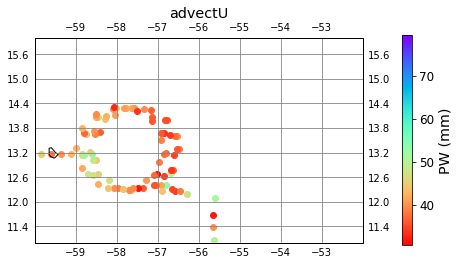

In [27]:
print("Show sondes location in the moving reference frame")

# var to plot
var = pw
var_lab = 'PW (mm)'
varname = 'pw'

# advection properties
advect_u = True
advect_v = False
u_plot,v_plot,advect_lab = advectProperties(advect_u,advect_v,u_adv,v_adv)
    
##-- Plot

fig = plt.figure(figsize=(np.diff(lon_box),np.diff(lat_box)))
# gs = gridspec.GridSpec(1, 2, width_ratios=[40,1])
gs = gridspec.GridSpec(1, 1, width_ratios=[1])

ax = plt.subplot(gs[0],projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.set_extent([*lon_box,*lat_box])
gl = ax.gridlines(color='Grey',draw_labels=True)
# gl.xlabel_style = {'size': 16}
# gl.ylabel_style = {'size': 16}

# show background?
# ax.imshow(im_hour,extent=[*lon_box_goes,*lat_box_goes],origin='upper')

# show sondes
x_s = data_day.longitude.dropna(dim='alt')
y_s = data_day.latitude.dropna(dim='alt')
# col = plt.rcParams['axes.prop_cycle'].by_key()['color'][:x_s.size]

# time increment
ref_time = (dt(2020,1,26)) + timedelta(hours=16)
# dtime = [(ref_time - dt.strptime(str(d)[:16],"%Y-%m-%dT%H:%M")) for d in data_day.launch_time.values] 

# colors
norm = matplotlib.colors.Normalize(vmin=var.min(), vmax=var.max())
cmap = plt.cm.rainbow_r
cols = cmap(norm(var),bytes=True) 

# show all points
for i_lt in range(data_day.dims['launch_time']):
    
    cur_time = dt.strptime(str(data_day.launch_time.values[i_lt])[:16],
                           "%Y-%m-%dT%H:%M")
    
    x,y = advect_coords(x_s[i_lt,0].values,
                        y_s[i_lt,0].values,
                        u_plot,v_plot,
                        ref_time,cur_time)
    
    ax.scatter(x,y,c=[cols[i_lt][:3]/255])

gl.top_labels = gl.right_labels = False
ax.set_title(advect_lab,pad=20)
    
#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.75,pad=0.09)
cb.set_label(var_lab)

# save figure
plt.savefig(os.path.join(figdir,'%s_%s_%s.pdf'%(varname,advect_lab,date.strftime("%Y%m%d"))),bbox_inches='tight')

## Detect the height and magnitude of radiative cooling peaks

Criteria used:

    . use a low-pass centered filter to detect the location and magnitude of the peak
    . the peak exceeds the noise in the rest of the profile (quality criterion to be added)

In [28]:
def findQradPeakLocation(values,n_smooth_0=15,return_all=False):
    """Returns a list of vertical indices for a given profile"""
    
    val_smooth_0 = np.convolve(values,np.repeat([1/n_smooth_0],n_smooth_0),
                             'same')
    
    ind = np.nanargmin(val_smooth_0)

    if return_all:
        return ind, val_smooth_0[ind], val_smooth_0
    else:
        return ind, val_smooth_0[ind]


In [29]:
def label_axis_subplot(axs,xlabel,ylabel,**kwargs):

    shape = axs.shape
    
    if len(shape) == 1:

        # X
        for ax in axs:
            ax.set_xlabel(xlabel,**kwargs)
        # Y
            ax.set_ylabel(ylabel,**kwargs)
       
    else:
        # X
        for ax in axs[-1,:]:

            ax.set_xlabel(xlabel,**kwargs)
        # Y
        for ax in axs[:,0]:

            ax.set_ylabel(ylabel,**kwargs)

In [30]:
print('example for given hour slice')

i_h = 22

class StopExecution(Exception):
    def _render_traceback_(self):
        pass
    
# time
time_init = pytz.utc.localize(dt(2020,1,26))
time_current = time_init+timedelta(hours=i_h)
time_label = time_current.strftime("%Y%m%d_%H")

# Data
mask = getMaskXYT(time_current,times,lon_box,lat_box,data_day,time_mode='hour')
data_hour = data_day.sel(launch_time=mask)
z = data_hour.zlay/1e3

cols = [plt.cm.nipy_spectral(x) for x in np.linspace(0,1,data_hour.dims['launch_time'])]

# figure shape and range
n_profs = data_hour.dims['launch_time']

if n_profs == 0:
    raise StopExecution

n_rows = int(np.sqrt(n_profs))
n_cols = ceil(n_profs/n_rows)
qrad_min = np.nanmin(data_hour.q_rad.values)
print(n_profs,n_cols,n_rows)

# make figure
fig, axs = plt.subplots(ncols=n_cols,nrows=n_rows,figsize=(4*n_cols,4.5*n_rows))

for i_lt,ax in zip(range(data_hour.dims['launch_time']),axs.flatten()):
    
    qrad = data_hour.q_rad.values[i_lt]
    ind,qrad_peak,qrad_smooth = findQradPeakLocation(qrad,return_all=True)
    hour_label = dt.strptime(str(data_hour.launch_time.values[i_lt])[:19],"%Y-%m-%dT%H:%M:%S").strftime("%Y-%m-%d %H:%M:%S")
    print(ind,hour_label)
    if ind is not None:
        z_peak = data_hour.alt[ind]
        
    ax.plot(data_hour.q_rad[i_lt],z,alpha=0.5,c=cols[i_lt])
    ax.plot(qrad_smooth,z,'k--')
    ax.scatter(qrad_peak,z_peak/1e3,marker='o',s=50,edgecolors='k',facecolors=cols[i_lt])
    
#     ax.set_xlabel(r'$Q_{rad}$ (K/day)')
#     ax.set_ylabel(r'z (km)')
    ax.set_title(hour_label)
    ax.set_xlim(qrad_min-0.2,3)
    ax.set_ylim(-0.2,4)

label_axis_subplot(axs,r'$Q_{rad}$ (K/day)',r'z (km)')
fig.tight_layout()
    
# save figure
plt.savefig(os.path.join(figdir,'qrad_prof_test_peak_detection_%s.pdf'%(time_label)),bbox_inches='tight')

example for given hour slice


TypeError: getMaskXYT() got multiple values for argument 'time_mode'

example for given hour slice
3 3 1
342 2020-01-26 02:43:16
236 2020-01-26 02:45:03
119 2020-01-26 02:50:46


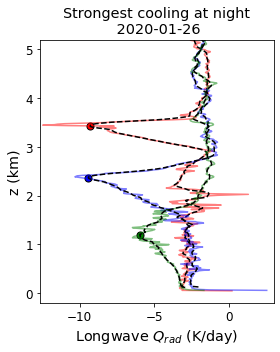

In [190]:
print('plot for slide to show on post EUREC4A informal symposium')

i_h = 2

class StopExecution(Exception):
    def _render_traceback_(self):
        pass
    
# time
time_init = pytz.utc.localize(dt(2020,1,26))
time_current = time_init+timedelta(hours=i_h)
time_label = time_current.strftime("%Y%m%d_%H")

# Data
mask = getMaskXYT(time_current,times,lon_box,lat_box,data_day,time_mode='hour')
data_hour = data_day.sel(launch_time=mask)
z = data_hour.zlay/1e3

# cols = [plt.cm.nipy_spectral(x) for x in np.linspace(0,1,data_hour.dims['launch_time'])]
cols = 'r','b','g'

# figure shape and range
n_profs = data_hour.dims['launch_time']

if n_profs == 0:
    raise StopExecution

n_rows = int(np.sqrt(n_profs))
n_cols = ceil(n_profs/n_rows)
qrad_min = np.nanmin(data_hour.q_rad.values)
print(n_profs,n_cols,n_rows)



# make figure
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(4,5))

for i_lt in range(data_hour.dims['launch_time']):
    
    qrad = data_hour.q_rad.values[i_lt]
    ind,qrad_peak,qrad_smooth = findQradPeakLocation(qrad,return_all=True)
    hour_label = dt.strptime(str(data_hour.launch_time.values[i_lt])[:19],"%Y-%m-%dT%H:%M:%S").strftime("%Y-%m-%d %H:%M:%S")
    print(ind,hour_label)
    if ind is not None:
        z_peak = data_hour.zlay[ind]
        
    ax.plot(data_hour.q_rad[i_lt],z,alpha=0.5,c=cols[i_lt])
    ax.plot(qrad_smooth,z,'k--')
    ax.scatter(qrad_peak,z_peak/1e3,marker='o',s=50,edgecolors='k',facecolors=cols[i_lt])
    
    ax.set_xlabel(r'Longwave $Q_{rad}$ (K/day)')
    ax.set_ylabel(r'z (km)')
    ax.set_title("Strongest cooling at night\n %s"%dt.strftime(date,"%Y-%m-%d"))
    ax.set_xlim(qrad_min-0.2,3)
    ax.set_ylim(-0.2,5.2)


label_axis_subplot(axs,r'$Q_{rad}$ (K/day)',r'z (km)')
fig.tight_layout()
    
# save figure
plt.savefig(os.path.join(figdir,'example_qrad_profiles_%s.pdf'%(time_label)),bbox_inches='tight')

(-3.3884320356951863, 3325)

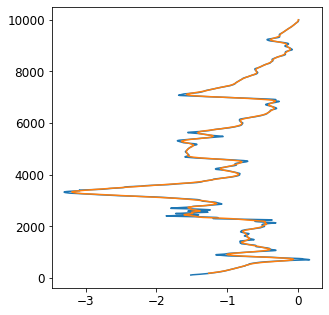

In [118]:
# DRAFT for code above

i_h = 12

time_init = pytz.utc.localize(dt(2020,1,26))
timedelta(hours=i_h)

mask_hour = np.logical_and(times > time_init+timedelta(hours=i_h), times <= time_init+timedelta(hours=i_h+1))
data_hour = data_day.sel(launch_time=mask_hour)


i_lt = 10

z = data_hour.zlay
values = np.convolve(data_hour.q_rad.values[i_lt],np.repeat([1/15],15),'same')
ind = np.nanargmin(values)
n_smooth = 15
val_smooth = np.convolve(values,np.repeat([1/n_smooth],n_smooth),'same')

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(values,z)
ax.plot(val_smooth,z)
# ax.plot(values-val_smooth,z)

data_hour.q_rad.values[i_lt,ind], data_hour.alt.values[ind]

In [59]:
print("Clean up peak detection")

class Features():
    """Finds and stores characteristics of the peak radiative cooling"""
    
    def __init__(self,dz_smooth=150):
        """Class constructor
        
        Arguments:
            - dz_smooth: filter width (default, 150m)"""
        
        self.dz_smooth = dz_smooth
        self.qrad_peak = None

    def __str__(self):
        """Override string function to print attributes
        """
        str_out = ''
        for a in dir(self):
            if '__' not in a:
                a_str = str(getattr(self,a))
                if 'array' in str(getattr(self,a).__class__):
                    str_out = str_out+("%s : %s\n"%(a,str(getattr(self,a).__class__)))
                elif 'method' not in a_str:
                    str_out = str_out+("%s = %s\n"%(a,a_str))
                
        return str_out


    def computeQradPeaks(self,data,which='net'):
        
        if self.qrad_peak is not None:
            print("Abort: qrad_peak is already computed")
            pass
        
        self.launch_time = data.launch_time.values
        self.z = data.alt.values
        dz = np.nanmean(np.diff(self.z))
        n_smooth = self.dz_smooth/dz
        
        # define
        setattr(self,'i_%s_peak'%which,np.nan*np.zeros((self.launch_time.size,),dtype=int))
        setattr(self,'z_%s_peak'%which,np.nan*np.zeros((self.launch_time.size,)))
        setattr(self,"qrad_%s_peak"%which,np.nan*np.zeros((self.launch_time.size,)))
        setattr(self,"qrad_%s_smooth"%which,np.nan*np.zeros((self.launch_time.size,self.z.size)))
        
        for i_lt in range(data.dims['launch_time']):
            
            if which == 'net':
                data_i = data.q_rad.values[i_lt]
            else:
                data_i = getattr(data,'q_rad_%s'%which).values[i_lt]
            i, qrad_i, qrad_s = self.findPeak(data_i,return_all=True)
            
            getattr(self,'i_%s_peak'%which)[i_lt] = i
            getattr(self,'z_%s_peak'%which)[i_lt] = self.z[i]
            getattr(self,'qrad_%s_peak'%which)[i_lt] = qrad_i
            getattr(self,'qrad_%s_smooth'%which)[i_lt,:] = qrad_s
            
        # convert to int (again..)
        setattr(self,'i_%s_peak'%which,np.array(getattr(self,'i_%s_peak'%which),dtype=int))
        
        setattr(self,'%s_peaks'%which,xr.Dataset({"launch_time":(["launch_time"], self.launch_time),\
                                 "z":(["zlay"],z),\
                                 "longitude":(["launch_time","zlay"],data.longitude.values),\
                                 "latitude":(["launch_time","zlay"],data.latitude.values),\
                                 "i_%s_peak"%which:(["launch_time"],getattr(self,'i_%s_peak'%which)),\
                                 "z_%s_peak"%which:(["launch_time"],getattr(self,'z_%s_peak'%which)),\
                                 "qrad_%s_peak"%which:(["launch_time"],getattr(self,'qrad_%s_peak'%which)),\
                                 "qrad_%s_smooth"%which:(["launch_time","zlay"],getattr(self,'qrad_%s_smooth'%which))}))

    def findPeak(self,values,n_smooth_0=15,return_all=False):
        """Returns index and value of radiative cooling peak.
        
        Arguments:
        - values: numpy array
        - n_smooth: width of smoothing window (number of points)
        - return_all: boolean
        
        Returns:
        - """
        
        val_smooth_0 = np.convolve(values,np.repeat([1/n_smooth_0],n_smooth_0),
                                 'same')

        ind = np.nanargmin(val_smooth_0)

        if return_all:
            return ind, val_smooth_0[ind], val_smooth_0
        else:
            return ind, val_smooth_0[ind]
        
    def computePW(self,data,i_z_max=-1,attr_name='pw'):
        """Compute and store precipitable water
        
        Arguments:
        - data: xarray"""

        # qv
        qv = data.specific_humidity.values
        # density
        t_lay = data.temperature.values
        R = 287 # J/kg/K
        p_lay = data.pressure.values
        rho_lay = p_lay/(R*t_lay)
        self.rho = rho_lay
        # dz
        dz = np.diff(data.alt_edges)
        dz = np.append(np.append([dz[0]],dz),[dz[-1]])
        dz_3D = np.repeat(dz[np.newaxis,:],t_lay.shape[0],axis=0)
        # PW
        pw_layers = qv*rho_lay*dz_3D
        
        if i_z_max.__class__ is int:
            setattr(self,attr_name,np.nansum(pw_layers[:,:i_z_max],axis=1))
        elif i_z_max.__class__ is np.ndarray:
            # truncate at height
            n_pw = pw_layers.shape[0]
            pw = np.nan*np.zeros((n_pw,))
            for i_pw in range(n_pw):
                i_z = i_z_max[i_pw]
                pw[i_pw] = np.nansum(pw_layers[i_pw,:i_z])
            setattr(self,attr_name,pw)

Clean up peak detection


In [60]:
# Initialize
f = Features()
# Find peaks in net Q_rad
f.computeQradPeaks(data_day,which='net')
# Find peaks in LW Q_rad
f.computeQradPeaks(data_day,which='lw')
# Compute PW
f.computePW(data_day)
# Compute PW truncated at qrad peak
f.computePW(data_day,i_z_max=f.i_net_peak,attr_name='pw_below_net_qrad_peak')
# Compute PW truncated at lw qrad peak
f.computePW(data_day,i_z_max=f.i_lw_peak,attr_name='pw_below_lw_qrad_peak')

## Show the radiative cooling peak properties

show all peak magnitudes in space


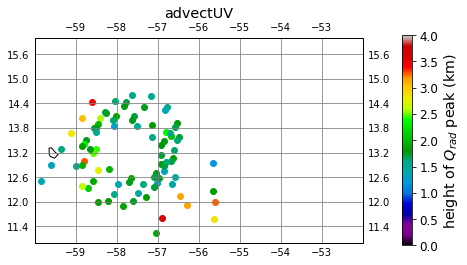

In [49]:
print("show all peak magnitudes in space")


# var to plot
var = f.lw_peaks.z.values[f.lw_peaks.i_lw_peak.values]
var_lab = 'height of $Q_{rad}$ peak (km)'
varname = 'z_qrad_lw'

# # var to plot -- height of peak 
# var = f.net_peaks.z.values[f.net_peaks.i_net_peak.values]
# var_lab = '$Q_{rad}$ (K/day)'
# varname = 'qrad_net'

# advection properties
advect_u = True
advect_v = True
u_plot,v_plot,advect_lab = advectProperties(advect_u,advect_v,u_adv,v_adv)

# colors
vmin = var.min()
vmax = var.max()
vmin = 0
vmax = 4
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
# cmap = plt.cm.rainbow_r
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var/1000),bytes=True) 

# reference time
ref_time = (dt(2020,1,26)) + timedelta(hours=16)


##-- Plot

fig = plt.figure(figsize=(np.diff(lon_box),np.diff(lat_box)))
gs = gridspec.GridSpec(1, 1, width_ratios=[1])

ax = plt.subplot(gs[0],projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.set_extent([*lon_box,*lat_box])
gl = ax.gridlines(color='Grey',draw_labels=True)

# sonde coordinates
x_s = f.net_peaks.longitude.dropna(dim='zlay')
y_s = f.net_peaks.latitude.dropna(dim='zlay')

# show all points
for i_lt in range(f.net_peaks.launch_time.values.size):

    cur_time = dt.strptime(str(f.net_peaks.launch_time.values[i_lt])[:16],
                           "%Y-%m-%dT%H:%M")

    x,y = advect_coords(x_s[i_lt,0].values,
                        y_s[i_lt,0].values,
                        u_plot,v_plot,
                        ref_time,cur_time)

    ax.scatter(x,y,c=[cols[i_lt][:3]/255])

gl.top_labels = gl.right_labels = False
ax.set_title(advect_lab,pad=20)
    
#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.75,pad=0.09)
cb.set_label(var_lab)

# save figure
plt.savefig(os.path.join(figdir,'%s_%s_%s.pdf'%(varname,advect_lab,date.strftime("%Y%m%d"))),bbox_inches='tight')

Show PW in Qrad-peak-time plane


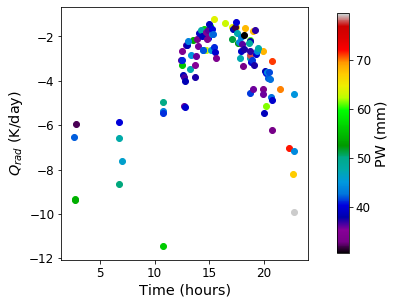

In [52]:
print("Show PW in Qrad-peak-time plane")

# colors
var_col = f.pw
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col),bytes=True) 

t = np.array([(pytz.utc.localize(dt.strptime(str(t)[:19],"%Y-%m-%dT%H:%M:%S")) - date).seconds/3600 for t in f.launch_time])

##-- plot
fig,ax = plt.subplots(figsize=(6,4.5))

for i_lt in range(f.launch_time.size):

    x = t[i_lt]
    y = f.qrad_net_peak[i_lt]

    ax.scatter(x,y,c=[cols[i_lt][:3]/255])
    
ax.set_xlabel(r'Time (hours)')
ax.set_ylabel(r'$Q_{rad}$ (K/day)')

#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label('PW (mm)')

# Save
plt.savefig(os.path.join(figdir,'Qrad_vs_time_colorPW_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')

Color by time in a PW-Qrad plane


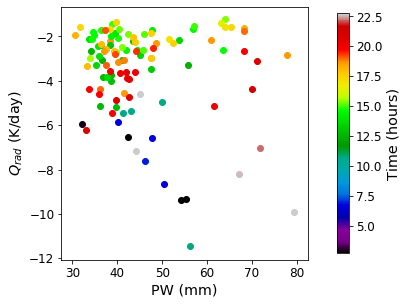

In [53]:
print("Color by time in a PW-Qrad plane")

# colors
var_col = np.array([(pytz.utc.localize(dt.strptime(str(t)[:19],"%Y-%m-%dT%H:%M:%S")) - date).seconds/3600 for t in f.launch_time])
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col),bytes=True) 

# filter in lon-lat box
# getMaskXYT(time_current,times,lon_box,lat_box,data_day,time_mode=None)

##-- plot
fig,ax = plt.subplots(figsize=(6,4.5))

for i_lt in range(f.launch_time.size):

    x = f.pw[i_lt]
    y = f.qrad_net_peak[i_lt]
    
    ax.scatter(x,y,c=[cols[i_lt][:3]/255])
    # ax.scatter(f.pw,f.qrad_peak,c=cols)
    
ax.set_xlabel(r'PW (mm)')
ax.set_ylabel(r'$Q_{rad}$ (K/day)')

#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label('Time (hours)')

# Save
plt.savefig(os.path.join(figdir,'Qrad_vs_PW_colorTime_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')

Color by time in a PW-Qrad_LW plane


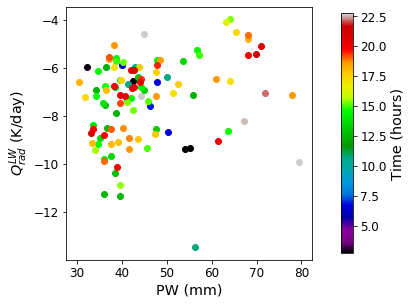

In [54]:
print("Color by time in a PW-Qrad_LW plane")

# colors
var_col = np.array([(pytz.utc.localize(dt.strptime(str(t)[:19],"%Y-%m-%dT%H:%M:%S")) - date).seconds/3600 for t in f.launch_time])
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col),bytes=True) 

# filter in lon-lat box
# getMaskXYT(time_current,times,lon_box,lat_box,data_day,time_mode=None)

##-- plot
fig,ax = plt.subplots(figsize=(6,4.5))

for i_lt in range(f.launch_time.size):

    x = f.pw[i_lt]
    y = f.qrad_lw_peak[i_lt]
    
    ax.scatter(x,y,c=[cols[i_lt][:3]/255])
    # ax.scatter(f.pw,f.qrad_peak,c=cols)
    
ax.set_xlabel(r'PW (mm)')
ax.set_ylabel(r'$Q_{rad}^{LW}$ (K/day)')

#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label('Time (hours)')

# Save
plt.savefig(os.path.join(figdir,'Qrad_LW_vs_PW_colorTime_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')

Color by peak height in a PW-Qrad plane


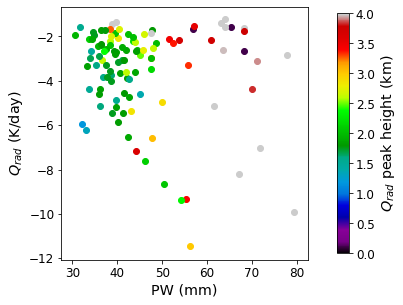

In [55]:
print("Color by peak height in a PW-Qrad plane")

# colors
var_col = f.net_peaks.z_net_peak.values/1000
norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col),bytes=True)


# filter in lon-lat box
# getMaskXYT(time_current,times,lon_box,lat_box,data_day,time_mode=None)

##-- plot
fig,ax = plt.subplots(figsize=(6,4.5))

for i_lt in range(f.launch_time.size):

    x = f.pw[i_lt]
    y = f.qrad_net_peak[i_lt]
    
    ax.scatter(x,y,c=[cols[i_lt][:3]/255])
    # ax.scatter(f.pw,f.qrad_peak,c=cols)
    
ax.set_xlabel(r'PW (mm)')
ax.set_ylabel(r'$Q_{rad}$ (K/day)')

#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label(r'$Q_{rad}$ peak height (km)')

# Save
plt.savefig(os.path.join(figdir,'Qrad_vs_PW_colorPeakHeight_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')

Color by peak height in a PW-Qrad_LW plane


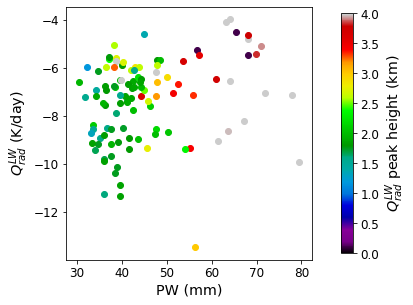

In [56]:
print("Color by peak height in a PW-Qrad_LW plane")

# colors
var_col = f.net_peaks.z_net_peak.values/1000
norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col),bytes=True)


# filter in lon-lat box
# getMaskXYT(time_current,times,lon_box,lat_box,data_day,time_mode=None)

##-- plot
fig,ax = plt.subplots(figsize=(6,4.5))

for i_lt in range(f.launch_time.size):

    x = f.pw[i_lt]
    y = f.qrad_lw_peak[i_lt]
    
    ax.scatter(x,y,c=[cols[i_lt][:3]/255])
    # ax.scatter(f.pw,f.qrad_peak,c=cols)
    
ax.set_xlabel(r'PW (mm)')
ax.set_ylabel(r'$Q_{rad}^{LW}$ (K/day)')

#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label(r'$Q_{rad}^{LW}$ peak height (km)')

# Save
plt.savefig(os.path.join(figdir,'Qrad_LW_vs_PW_colorPeakHeight_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')

## Show radiative cooling profiles as a function of PW

In [57]:
print("show Qrad profiles as a function of PW")

show Qrad profiles as a function of PW


In [109]:
# data = data_day

# # qv
# qv = data.h2o.values
# # density
# t_lay = data.tlay.values
# R = 287 # J/kg/K
# p_lay = data.play.values
# rho_lay = p_lay/(R*t_lay)
# # dz
# dz = np.diff(data.zlev)
# dz_3D = np.repeat(dz[np.newaxis,:],t_lay.shape[0],axis=0)
# # PW
# pw_layers = qv*rho_lay*dz_3D
# pw = np.nansum(pw_layers,axis=1)


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


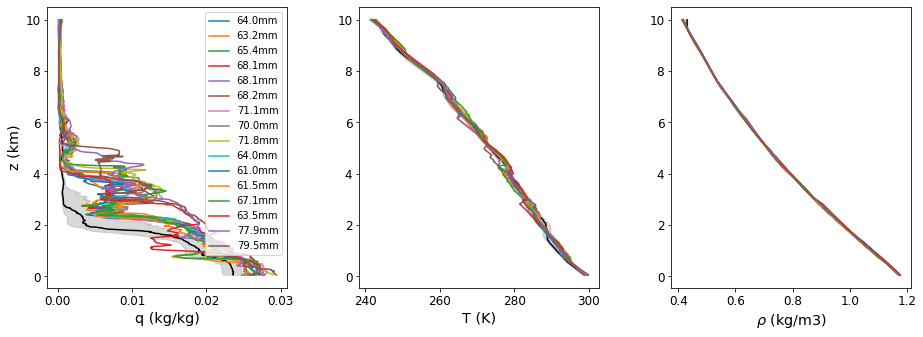

In [62]:
ind_pw_large = f.pw > 60
n_c = np.sum(ind_pw_large)

fig,axs = plt.subplots(ncols=3,figsize=(16,5))

vars2show = [data_day.specific_humidity,data_day.temperature,f.rho]
var_labels = ['q (kg/kg)','T (K)',r'$\rho$ (kg/m3)']

nvars = len(vars2show)

for i_v,var in zip(range(nvars),vars2show):

    # show mean and interquartile range for each variable
    v_mean = np.nanmean(var,axis=0)
    v_25 = np.apply_along_axis(lambda x:np.percentile(x,25),0,var)
    v_50 = np.apply_along_axis(lambda x:np.percentile(x,50),0,var)
    v_75 = np.apply_along_axis(lambda x:np.percentile(x,75),0,var)
    
    axs[i_v].fill_betweenx(f.z/1e3,v_25,v_75,color='grey',alpha=0.3)
    axs[i_v].plot(v_50,f.z/1e3,'k')
    
    for i_c in range(n_c):

        lab_c = None
        if i_v == 0:
            lab_c = '%2.1fmm'%(f.pw[ind_pw_large][i_c])
        
        axs[i_v].plot(var[ind_pw_large][i_c],f.z/1e3,label=lab_c)
        
    axs[i_v].set_xlabel(var_labels[i_v])

axs[0].set_ylabel('z (km)')
axs[0].legend()

# Save
plt.savefig(os.path.join(figdir,'Qrad_LW_vs_PW_colorPeakHeight_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')

In [63]:
## Add own library to path
moduledir = '/Users/bfildier/Code/dev_python/conditional-stats/src'
sys.path.insert(0,moduledir)
for includedir in [moduledir]:
    print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                     for x in glob.glob(os.path.join(includedir,'*.py'))])

from conditionalstats import *

Own modules available: ['conditionalstats']


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


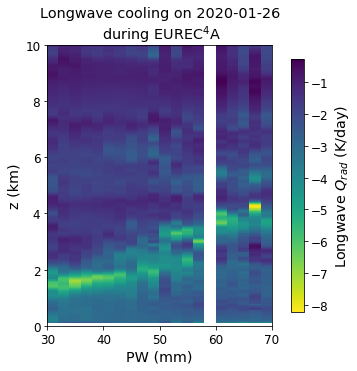

In [64]:

##-- reference pw values
pw_bins = np.linspace(30,70,21)
pw_centers = np.convolve(pw_bins,[0.5,0.5], mode='valid')

# dims
n_pw = pw_centers.size
# n_qrad = data_day.dims['launch_time']
n_z = f.z.size

##-- conditional distribution
qrad_on_pw = np.nan*np.zeros((n_pw,n_z))

for i_pw in range(n_pw):
    
    pw_min = pw_bins[i_pw]
    pw_max = pw_bins[i_pw+1]

    inds_qrad = np.logical_and(f.pw > pw_min,f.pw <= pw_max)
    qrad_on_pw[i_pw] = np.nanmean(f.lw_peaks.qrad_lw_smooth[inds_qrad,:],axis=0)


##-- show
cmap=plt.cm.viridis_r

fig,ax = plt.subplots(figsize=(6,5))

h = ax.imshow(qrad_on_pw.T,
          aspect=5,
          origin='lower',
          extent=[pw_bins[0],pw_bins[-1],f.z[0]/1000,f.z[-1]/1000],
          cmap=cmap)

ax.set_xlabel('PW (mm)')
ax.set_ylabel('z (km)')
ax.set_title('Longwave cooling on %s\n during EUREC$^4$A'%date.strftime("%Y-%m-%d"))

# colorbar
# plt.colorbar(h)
norm = matplotlib.colors.Normalize(vmin=np.nanmin(qrad_on_pw), vmax=np.nanmax(qrad_on_pw))
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.9,pad=0.06)
cb.set_label(r'Longwave $Q_{rad}$ (K/day)')

plt.savefig(os.path.join(figdir,'Qrad_LW_on_z_vs_PW_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')

## Check PW values

check PW values, comparing HALO sondes only with IWV estimates by Geet


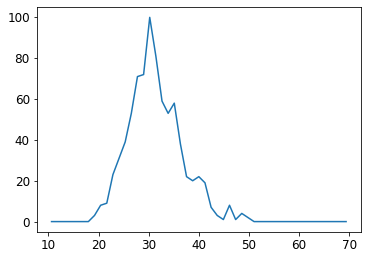

In [75]:
print("check PW values, comparing HALO sondes only with IWV estimates by Geet")

ds_iwv_geet = xr.open_dataset(os.path.join('/Users/bfildier/Dropbox/Data/EUREC4A/l3_HALOiwv.nc'))


bins = np.linspace(10,70)
dens,bins = np.histogram(ds_iwv_geet.iwv,bins=bins)
bins_c = np.convolve(bins,[0.5,0.5],mode='valid')
plt.plot(bins_c,dens)

In [80]:
inds_qrad = np.logical_and(data.platform == 'HALO')

qrad_on_pw[i_pw] = np.nanmean(f.lw_peaks.qrad_lw_smooth[inds_qrad,:],axis=0)


TypeError: where() got an unexpected keyword argument 'platform'

In [ ]:
# Initialize
f_all = Features()
# Compute PW
f_HALO.computePW(data_HALO)